In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [5]:
df = pd.read_csv('data/StudentsPerformance.csv')


In [6]:
x = df.drop(columns=['math score', 'reading score', 'writing score'])
y = df[['math score', 'reading score', 'writing score']]


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = x.select_dtypes(include=['object']).columns.tolist()
transformer = OneHotEncoder()
preprocessor = ColumnTransformer([('OneHotEncoder', transformer, categorical_features)])


In [8]:
preprocessed_x = preprocessor.fit_transform(x)

In [9]:
preprocessed_x

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5000 stored elements and shape (1000, 17)>

In [10]:
train_x, test_x, train_y, test_y = train_test_split(preprocessed_x, y, test_size=0.2, random_state=42)

In [11]:
def evaluate_model(true,predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2 = r2_score(true, predicted)
    return mse, r2, mae, rmse

In [12]:
from sklearn.multioutput import MultiOutputRegressor  # ensure available if imports cell not run
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": MultiOutputRegressor(XGBRegressor()),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor()),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "AdaBoost": MultiOutputRegressor(AdaBoostRegressor()),
    "Decision Tree": DecisionTreeRegressor()
}
model_list = []
model_performance = []
for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(train_x, train_y)
    predicted = model.predict(test_x)
    mse_train, r2_train, mae_train, rmse_train = evaluate_model(train_y, model.predict(train_x))
    mse_test, r2_test, mae_test, rmse_test = evaluate_model(test_y, predicted)
    model_list.append(list(models.keys())[i])
    print(f"Model: {list(models.keys())[i]}")
    print(f"Train MSE: {mse_train}, R2 Score: {r2_train}, MAE: {mae_train}, RMSE: {rmse_train}")
    print(f"Test MSE: {mse_test}, R2 Score: {r2_test}, MAE: {mae_test}, RMSE: {rmse_test}")
    print("-"*50)
    model_performance.append({
        'MSE': mse_test,
        'R2 Score': r2_test,
        'MAE': mae_test,
        'RMSE': rmse_test
    })

Model: Linear Regression
Train MSE: 157.89261009645574, R2 Score: 0.28271968784498175, MAE: 10.225424996956908, RMSE: 12.565532622871812
Test MSE: 189.3928508328888, R2 Score: 0.1997106173553144, MAE: 10.764434830693629, RMSE: 13.762007514635675
--------------------------------------------------
Model: Random Forest
Train MSE: 126.49345521592409, R2 Score: 0.42548948474798937, MAE: 9.025304099238644, RMSE: 11.246930924297708
Test MSE: 230.35183227398423, R2 Score: 0.02687046158802912, MAE: 11.742049810783934, RMSE: 15.177346022081206
--------------------------------------------------
Model: XGBoost
Train MSE: 125.02388763427734, R2 Score: 0.4321826696395874, MAE: 8.865135192871094, RMSE: 11.181408123947419
Test MSE: 242.6781463623047, R2 Score: -0.025394201278686523, MAE: 12.07907772064209, RMSE: 15.578130387254586
--------------------------------------------------
Learning rate set to 0.039525
0:	learn: 14.8804682	total: 156ms	remaining: 2m 35s
1:	learn: 14.7487380	total: 157ms	remain

In [13]:
# Safely build a numeric performance table from collected metric dicts
perf_df = pd.DataFrame(model_performance)  # each entry is a dict of metrics
perf_df['Model'] = model_list
# Ensure numeric columns exist and fill missing metrics with NaN
for col in ['MSE','R2 Score','MAE','RMSE']:
    if col not in perf_df.columns:
        perf_df[col] = pd.NA
# Convert numeric-like columns to floats where possible
for col in ['MSE','R2 Score','MAE','RMSE']:
    perf_df[col] = pd.to_numeric(perf_df[col], errors='coerce')
# Reorder to put Model first
cols = ['Model','R2 Score','MSE','MAE','RMSE']
cols = [c for c in cols if c in perf_df.columns] + [c for c in perf_df.columns if c not in cols]
perf_df = perf_df[cols]
# Sort: prefer R2 Score descending, otherwise MSE ascending
if 'R2 Score' in perf_df.columns and perf_df['R2 Score'].notna().any():
    perf_df_sorted = perf_df.sort_values(by='R2 Score', ascending=False, ignore_index=True)
else:
    perf_df_sorted = perf_df.sort_values(by='MSE', ascending=True, ignore_index=True)
perf_df_sorted

,Model,R2 Score,MSE,MAE,RMSE
0,Linear Regression,0.199711,189.392851,10.764435,13.762008
1,Ridge,0.199509,189.440424,10.766527,13.763736
2,AdaBoost,0.128152,206.299125,11.175575,14.363117
3,Lasso,0.102783,212.421946,11.409434,14.574702
4,Random Forest,0.026870,230.351832,11.742050,15.177346
5,CatBoost,0.000078,236.616440,11.937295,15.382342
6,XGBoost,-0.025394,242.678146,12.079078,15.578130
7,Decision Tree,-0.032950,244.432117,12.187709,15.634325
8,K-Nearest Neighbors,-0.073421,254.166933,12.600667,15.942614


In [14]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(train_x, train_y)
y_pred = lin_model.predict(test_x)
score = r2_score(test_y,y_pred)
score

0.1997106173553144

Text(0, 0.5, 'Predicted')

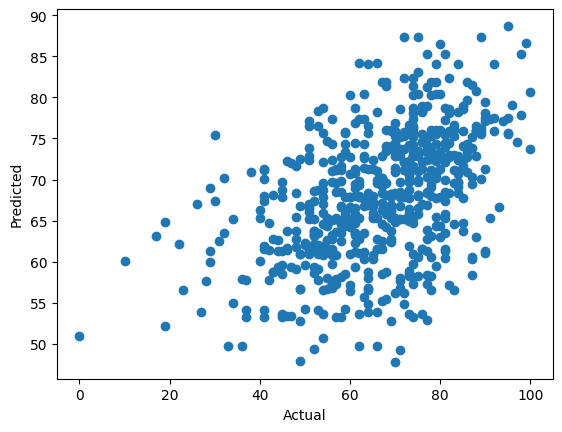

In [15]:
plt.scatter(test_y,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')


In [16]:
pred_df = pd.DataFrame({'Actual' : 'test_y','Predicted' : 'y_pred','Difference' : 'test_y - y_pred'})
pred_df

ValueError: If using all scalar values, you must pass an index